<a href="https://colab.research.google.com/github/shubham-ai/PytorchCNN_cars_model_year/blob/master/PytorchConvNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/classificationProject/cars-10'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/classificationProject/cars-10


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

import torch
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from skimage import io, transform
import cv2


In [8]:
import glob
from PIL import Image
classes=[i for i in range(0,10)]
images_train= sorted(glob.glob("train/*jpg"))
images_val  = sorted(glob.glob("val/*jpg"))
images_test = sorted(glob.glob("test/*jpg"))
t_label=np.load('train.label.npy',mmap_mode='r')
v_label = np.load('val.label.npy',mmap_mode='r')
print(len(v_label),len(images_val),len(t_label),len(images_test))
assert len(v_label)==len(images_val),'not equal val set'
assert len(t_label)==len(images_train),'not equal test set'
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images_train[0]


48 48 388 423


'train/00000.jpg'

In [9]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
class mnistmTrainingDataset(torch.utils.data.Dataset):

    def __init__(self,images,label,transform=train_transforms):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.images = images
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image = Image.open('./'+self.images[idx])
        image = image.convert('RGB')
        image = self.transform(image)
        labels = self.label[idx]
        #labels = labels.reshape(-1, 2)
        sample = [image,np.long(labels)]

        return sample


train_data = mnistmTrainingDataset(images_train,t_label)
val_data = mnistmTrainingDataset(images_val,v_label)
test_data = mnistmTrainingDataset(images_test,[0 for i in range(0,len(images_test))])


trainloader = torch.utils.data.DataLoader(train_data,batch_size=16,shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_data,batch_size=16,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data,batch_size=16,shuffle=True, num_workers=2)



train_loader= iter(trainloader)
imgs, label = next(train_loader)

imgs.shape, label.shape,label.type()



(torch.Size([16, 3, 224, 224]), torch.Size([16]), 'torch.LongTensor')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

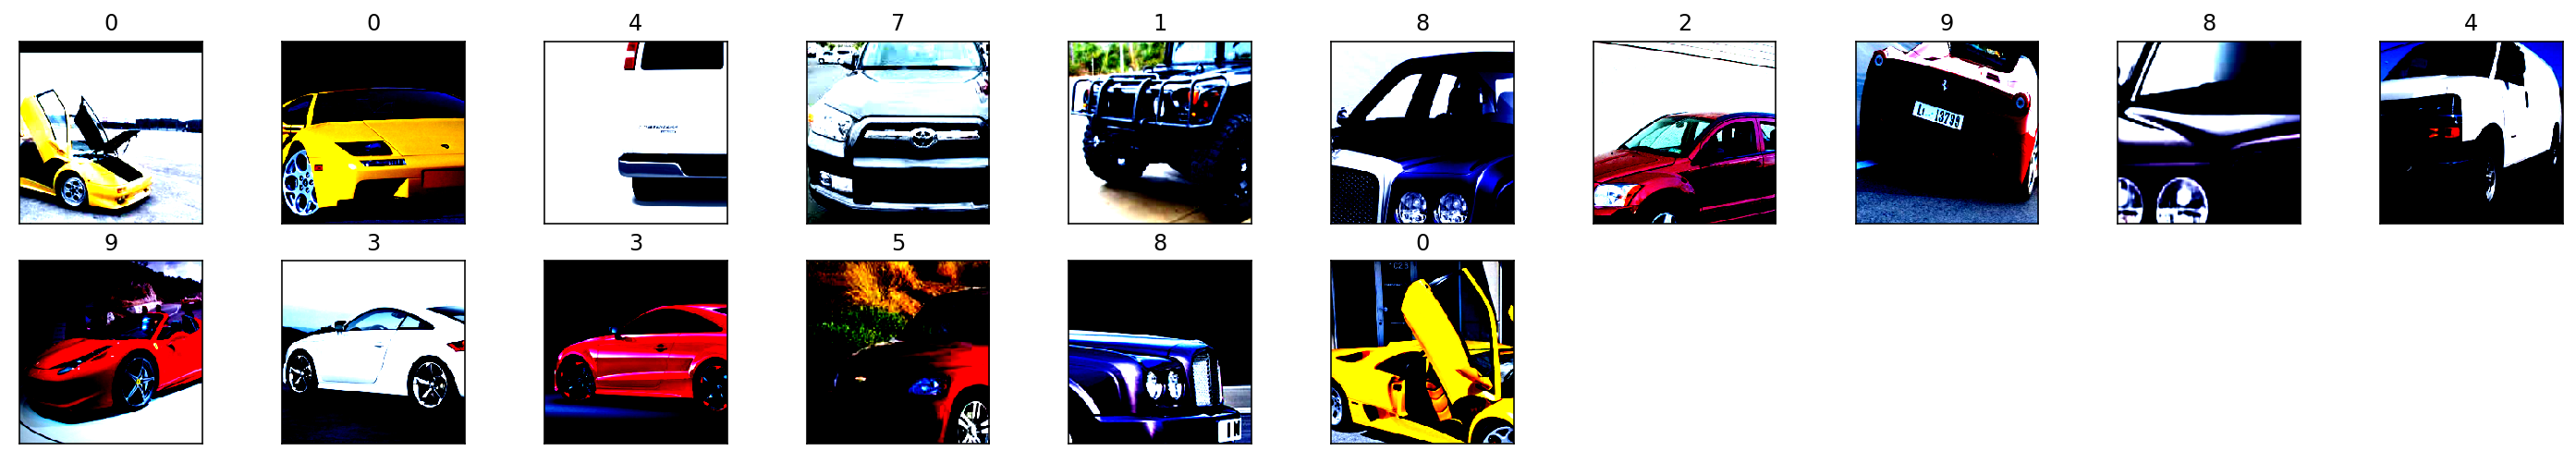

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Dense net**

In [16]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 14.4MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [20]:
for param in model.parameters():
    param.requires_grad = False

# from collections import OrderedDict
# classifier = nn.Sequential(OrderedDict([
#                           ('fc1', nn.Linear(1024, 500)),
#                           ('relu', nn.ReLU()),
#                           ('fc2', nn.Linear(500, 10)),
#                           ('output', nn.LogSoftmax(dim=1))
#                           ]))
    
# model.classifier = classifier

import torch.nn as nn

n_inputs = model.classifier.in_features

last_layer = nn.Linear(n_inputs, 10)

model.classifier = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

# check to see that your last layer produces the expected number of outputs
print(model.classifier.out_features)


10


In [0]:
def modelFormation():
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
      param.requires_grad = False

    import torch.nn as nn

    n_inputs = model.classifier.in_features

    last_layer = nn.Linear(n_inputs, 10)

    model.classifier = last_layer

    # if GPU is available, move the model to GPU
    if train_on_gpu:
        model.cuda()

    # check to see that your last layer produces the expected number of outputs
    print(model.classifier.out_features)

    return model

In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

In [0]:
epochs = 100
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []


for epoch in range(epochs):
    for inputs, labels in trainloader:

        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            val_loss = 0
            accuracy = 0
            model.eval() # it will turn off droup out to 0 
            # model.eval() also called turning model in inference or validation mode
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    val_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(val_loss/len(valloader))

 
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"val loss: {val_loss/len(valloader):.3f}.. "
                  f"val accuracy: {accuracy/len(valloader):.3f}")
            running_loss = 0
            model.train # turn on dropout again

Epoch 1/100.. Train loss: 2.336.. val loss: 2.237.. val accuracy: 0.188
Epoch 1/100.. Train loss: 2.270.. val loss: 2.232.. val accuracy: 0.250
Epoch 1/100.. Train loss: 2.256.. val loss: 2.250.. val accuracy: 0.146
Epoch 1/100.. Train loss: 2.305.. val loss: 2.229.. val accuracy: 0.208
Epoch 1/100.. Train loss: 2.213.. val loss: 2.160.. val accuracy: 0.229
Epoch 2/100.. Train loss: 2.199.. val loss: 2.144.. val accuracy: 0.271
Epoch 2/100.. Train loss: 2.188.. val loss: 2.159.. val accuracy: 0.208
Epoch 2/100.. Train loss: 2.140.. val loss: 2.163.. val accuracy: 0.229
Epoch 2/100.. Train loss: 2.109.. val loss: 2.069.. val accuracy: 0.354
Epoch 2/100.. Train loss: 2.098.. val loss: 2.129.. val accuracy: 0.250
Epoch 3/100.. Train loss: 2.101.. val loss: 2.049.. val accuracy: 0.271
Epoch 3/100.. Train loss: 2.040.. val loss: 2.052.. val accuracy: 0.292
Epoch 3/100.. Train loss: 2.072.. val loss: 2.032.. val accuracy: 0.333
Epoch 3/100.. Train loss: 2.062.. val loss: 1.985.. val accuracy

In [0]:
torch.save(model.state_dict(), "Checkpoint2.pth")

In [11]:
model = modelFormation()
model.load_state_dict(torch.load("Checkpoint2.pth"))
model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 109MB/s]


10


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

9
1
1
0
9
0
2
8
8
5
8
8
1
7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
4


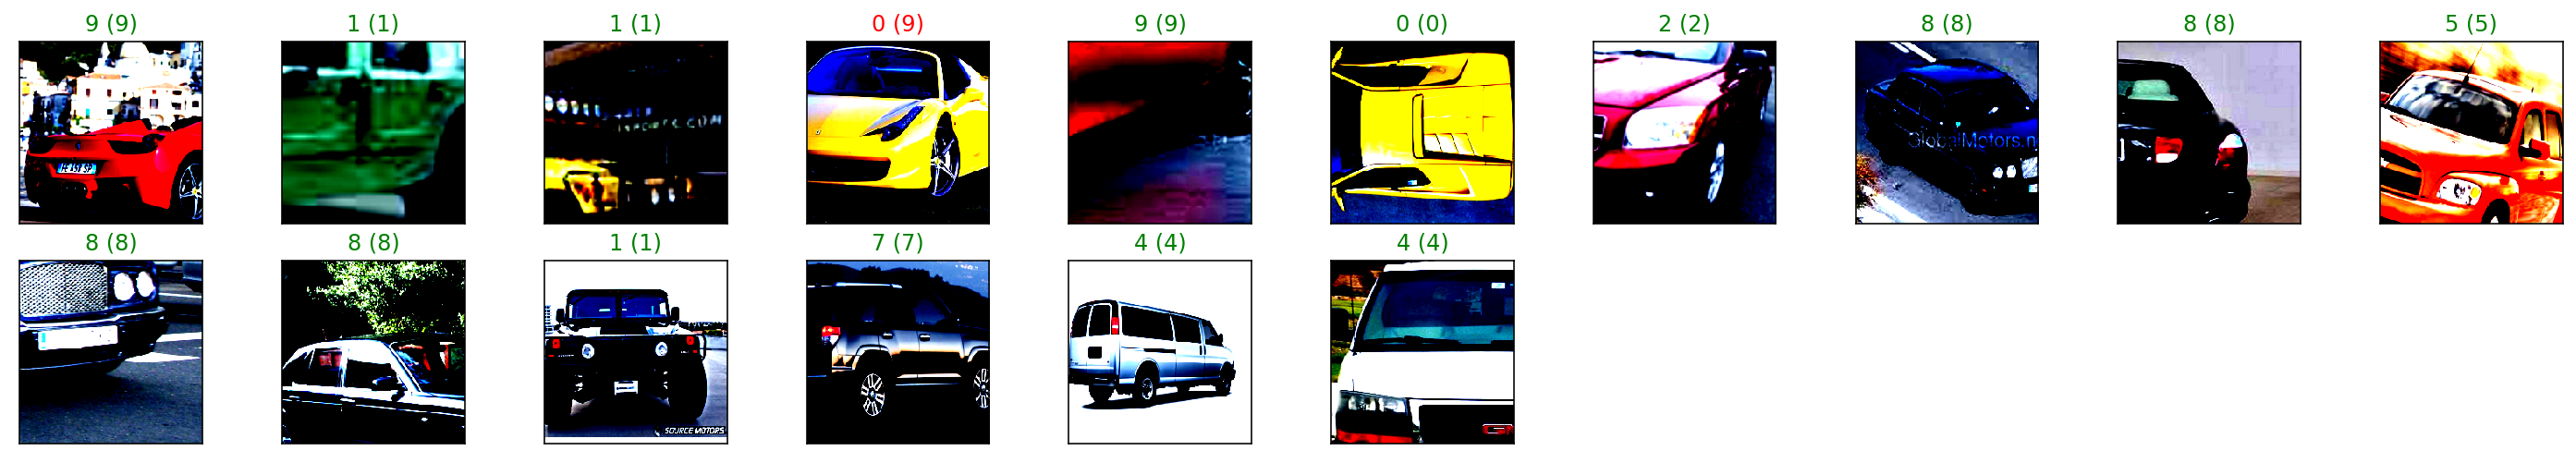

In [13]:
# obtain one batch of test images
classes = [i for i in  range(0,16)]
train_on_gpu = torch.cuda.is_available()


dataiter = iter(valloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_,preds_tensor = torch.max(output, 1)
# print(preds_tensor==labels,preds_tensor,labels)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
## plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    print(classes[preds[idx]])
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [16]:
arr=[]
for idx,(images,labels) in enumerate(testloader):
  images.numpy()

  # move model inputs to cuda, if GPU available
  if train_on_gpu:
      images = images.cuda()

  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _,preds_tensor = torch.max(output, 1)
  # print(preds_tensor==labels,preds_tensor,labels)
  preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
  arr=np.concatenate((arr,preds))
  
print(arr)

[9. 4. 4. 2. 9. 0. 9. 0. 4. 1. 7. 1. 0. 8. 4. 8. 1. 4. 0. 4. 6. 4. 3. 2.
 0. 8. 9. 0. 6. 2. 4. 4. 2. 8. 7. 1. 5. 9. 4. 1. 6. 4. 6. 4. 0. 6. 4. 2.
 1. 7. 8. 9. 7. 6. 9. 9. 7. 7. 3. 0. 7. 2. 3. 2. 7. 7. 9. 0. 4. 4. 2. 4.
 8. 0. 3. 4. 9. 4. 6. 8. 8. 5. 4. 0. 4. 2. 4. 1. 0. 4. 4. 3. 3. 7. 4. 3.
 8. 4. 5. 7. 4. 1. 8. 2. 6. 2. 2. 4. 2. 1. 3. 4. 5. 3. 4. 4. 0. 0. 4. 3.
 1. 1. 1. 3. 6. 2. 9. 1. 8. 2. 9. 1. 2. 9. 9. 9. 2. 4. 7. 0. 4. 9. 7. 6.
 3. 1. 2. 7. 8. 0. 0. 0. 1. 1. 6. 8. 6. 9. 6. 1. 4. 8. 9. 4. 5. 8. 1. 4.
 0. 5. 7. 4. 4. 3. 9. 2. 2. 2. 5. 2. 8. 8. 4. 4. 5. 1. 3. 2. 8. 9. 2. 6.
 3. 9. 8. 6. 0. 7. 5. 6. 8. 1. 3. 2. 6. 4. 7. 2. 0. 9. 3. 1. 9. 4. 1. 2.
 7. 8. 4. 4. 8. 2. 8. 6. 4. 1. 7. 4. 5. 1. 8. 3. 7. 2. 5. 2. 0. 9. 6. 8.
 1. 3. 0. 1. 3. 3. 3. 7. 4. 8. 9. 1. 8. 3. 2. 6. 4. 7. 1. 1. 6. 9. 7. 2.
 9. 7. 0. 9. 5. 9. 3. 4. 5. 3. 6. 8. 4. 3. 4. 8. 5. 5. 5. 2. 9. 2. 8. 8.
 7. 5. 0. 3. 4. 4. 9. 4. 3. 0. 4. 0. 8. 7. 4. 7. 3. 5. 1. 4. 5. 0. 0. 8.
 0. 5. 9. 3. 2. 1. 5. 8. 0. 1. 6. 2. 3. 9. 3. 3. 4.

In [18]:
arr.shape

(423,)

In [0]:
np.savetxt('Test_data_predictions.txt', arr)


In [20]:
from collections import Counter
Counter(arr)

Counter({0.0: 44,
         1.0: 43,
         2.0: 44,
         3.0: 35,
         4.0: 74,
         5.0: 30,
         6.0: 32,
         7.0: 34,
         8.0: 43,
         9.0: 44})